# Exercise 6: Multi-Step Bootstrapping

In this exercise we will have a look at n-step methods and eligibility trace. The n-step methods are a class of reinforcement learning algorithms that are an abstraction of the Monte Carlo and TD(0) methods discussed earlier and include them as special cases. Furthermore, we also consider the eligibility traces, which take a reverse approach to determining the state values. The environment we will be dealing with is a little more typical for control research: the inverted pendulum. 

![](https://miro.medium.com/max/1000/1*TNo3x9zDi1lVOH_3ncG7Aw.gif)

To implement this environment, we will make use of the gymnasium library. Please install the gymnasium library within your preferred Python environment using:

```pip install gymnasium```

**Note: Use ```done = terminated or truncated``` for the end of the episode**

Note that the episodes in this environment end with a truncation and not a termination. For this exercise, we assume that for the environment truncation and termination is the same. That is wherever, we are looking for a terminal state we instead look for the state where the episode is truncated! (Generally, termination and truncation are different things. This is the case because the timelimit is not actually part of the MDP but rather a constraint set from the outside. More on this [here](https://gymnasium.farama.org/tutorials/gymnasium_basics/handling_time_limits/))

In [3]:
import numpy as np
import gymnasium as gym
from gymnasium.wrappers import TimeLimit
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
plt.style.use('seaborn')

C:\Users\jakobeit\AppData\Local\Temp\ipykernel_10688\3939670735.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


Check if the installation and import work by executing the following cell. A window with an animation of the pendulum should open, display some random actions, and close automatically.

In [4]:
env = gym.make('Pendulum-v1', render_mode="human")
env = env.unwrapped  # removes a built-in time limit of k_T = 200, we want to set the time limit ourselves
env = TimeLimit(env, max_episode_steps = 300)

state, _ = env.reset()
for _ in range(300):
    env.render()
    state, reward, terminated, truncated, _ = env.step(env.action_space.sample()) # take a random action
    done = terminated or truncated
env.close()

The goal of this environment is to bring the pendulum into the upper neutral position, where the angle $\theta = 0$ and the angular velocitiy $\frac{\text{d}}{\text{d}t}\theta=\omega=0$. The reward function is already designed that way and does not need further specification. For further information about the environment you may refer to the code and documentation of Farama Foundation's `gymnasium`:

[Documentation of the gymnasium pendulum](https://gymnasium.farama.org/environments/classic_control/pendulum/)

[Pendulum environment in the gymnasium Github repository](https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/classic_control/pendulum.py)

## Discretization of Action and State Space

Unlike the racetrack environment, the inverted pendulum comes with a continuous action and state space. Although it is possible to handle systems with these characteristics, we did not yet learn how to deal with them. For now, we only know how to implement agents for discrete action and state spaces. As a result, we will also try to represent the inverted pendulum within a discrete state / action space through discretization.

The pendulum has three state variables relating to the momentary angular position $\theta$:
$$
\begin{align*}
    x=\begin{bmatrix}
    \text{cos}(\theta)\\
    \text{sin}(\theta)\\
    \frac{\text{d}}{\text{d}t}\theta
    \end{bmatrix}
    \in
    \begin{bmatrix}
    [-1, 1]\\
    [-1, 1]\\
    [-8 \, \frac{1}{\text{s}}, 8 \, \frac{1}{\text{s}}]
    \end{bmatrix},
\end{align*}
$$
and one input variable which relates to the torque applied at the axis of rotation:

$$
\begin{align*}
    u = T \in [-2 \, \text{N}\cdot\text{m}, 2 \, \text{N}\cdot\text{m}]
\end{align*}
$$

After the discretization, we want the system to be defined on sets of non-negative natural numbers:


$$
\begin{align*}
    x_d =
    \text{discretize\_state}(x)
    \in
    \begin{bmatrix}
    \{0,1,2,...,d_{\theta}-1\}\\
    \{0,1,2,...,d_{\theta}-1\}\\
    \{0,1,2,...,d_{\omega}-1\}
    \end{bmatrix},
\end{align*}
$$

$$
\begin{align*}
    u_d =
    \text{discretize\_action}(u)
    \in
    \{0,1,2,...,d_{T}-1\}.
\end{align*}
$$

Since action is selected within the discrete action space, we need to transform it accordingly:

$$
\begin{align*}
    u=
    \text{continualize\_action}(u_d):
    \{0,1,2,...,d_{T}-1\} \rightarrow [-2 \, \text{N}\cdot\text{m}, 2 \, \text{N}\cdot\text{m}]
    .
\end{align*}
$$

Below the functions `discretize_state` and `continualize_action` are given, such that a discrete RL agent can be applied. (Please note that all I/O of `gymnasium` consists of numpy arrays.) The discretization intervals $d_\theta, d_\omega, d_T$ are parameters that can be changed for different tests. The discretization intervals should are uniformly distributed on their respective state space.

A parametrization of $d_\theta = d_\omega = d_T = 15$ can be used to yield satisfactory results in this exercise.
However, does it make a difference if the number of discretization intervals is odd or even? If yes, what should be preferred for the given environment? 

The number of discretization intervals can in fact make a difference in this case. The inverted pendulum can be considered as solved when brought into the upper neutral position $\theta=0, \omega=0$. The state as given by `gymnasium` would therefore be:

\begin{align*}
x_\text{neutral}=
\begin{bmatrix}
\text{cos}(0)\\
\text{sin}(0)\\
0
\end{bmatrix}
=
\begin{bmatrix}
1\\
0\\
0
\end{bmatrix},
u_\text{neutral}=0
\end{align*}

Consequently, the discretization / continualization should allow for precise transformation of this state, which is given when assuming an odd number of discretization intervals. If one uses an even number of intervals, one interval boundary will be located exactly at zero, potentially leading to rapid bouncing around the neutral position.

In [5]:
d_theta = 15
d_omega = 15
d_T = 15

def discretize_state(states):
    limits = [1, 1, 8]
    nb_disc_intervals = [d_theta, d_theta, d_omega]

    # bring to value range [-1, 1]
    norm_states = [state / limit for state, limit in zip(states, limits)]
    interval_lengths = [2 / d for d in nb_disc_intervals]
    disc_state = [(norm_state + 1) // interval_length for norm_state,
                  interval_length in zip(norm_states, interval_lengths)]
    disc_state = [(state - 1) if state == d else state for state,
                  d in zip(disc_state, nb_disc_intervals)]  # ensure that disc_state < d

    return np.array(disc_state, dtype=int)


def continualize_action(disc_action):
    limit = 2
    interval_length = 2 / (d_T-1)
    norm_action = disc_action * interval_length
    cont_action = (norm_action - 1) * limit
    return np.array(cont_action).flatten()

Use the following cell for debugging:

In [6]:
env = gym.make('Pendulum-v1', render_mode="human")
state, _ = env.reset()
for _ in range(5):
    disc_action = np.random.choice(range(9))
    cont_action = continualize_action(disc_action)
    print("discrete action: {}, continuous action: {}".format(disc_action, cont_action))
    
    state, reward, terminated, truncated, _ = env.step(cont_action) # take a random action
    done = terminated or truncated
    disc_state = discretize_state(state)
    print("discrete state: {}, continuous state: {}".format(disc_state, state))
    
env.close()

discrete action: 2, continuous action: [-1.42857143]
discrete state: [ 5 14  7], continuous state: [-0.28895155  0.9573437   0.20548677]
discrete action: 6, continuous action: [-0.28571429]
discrete state: [ 5 14  8], continuous state: [-0.3308115   0.94369686  0.8806374 ]
discrete action: 6, continuous action: [-0.28571429]
discrete state: [ 4 14  8], continuous state: [-0.40267834  0.91534156  1.545553  ]
discrete action: 8, continuous action: [0.28571429]
discrete state: [ 3 13  9], continuous state: [-0.5039681   0.86372226  2.2749162 ]
discrete action: 4, continuous action: [-0.85714286]
discrete state: [ 2 13 10], continuous state: [-0.6193336   0.78512794  2.7941365 ]


## Discretization Diagrams

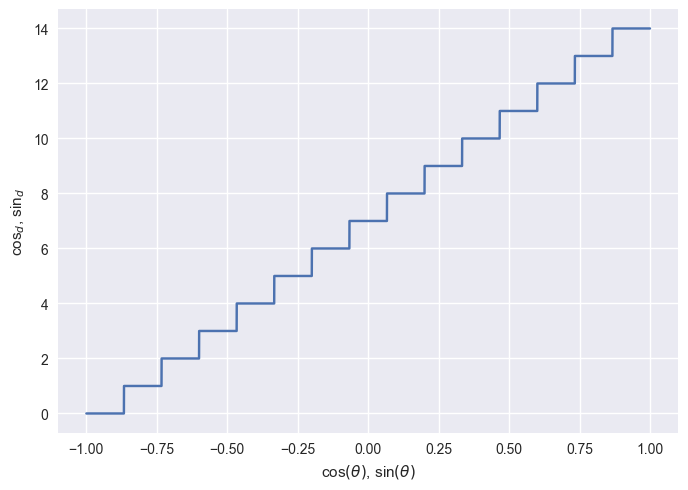

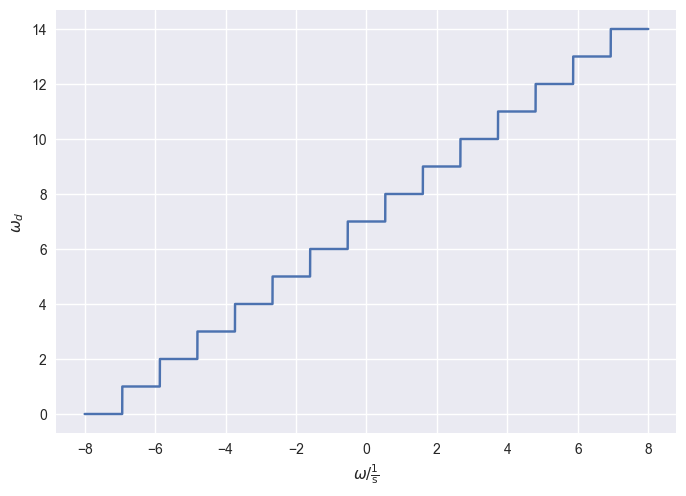

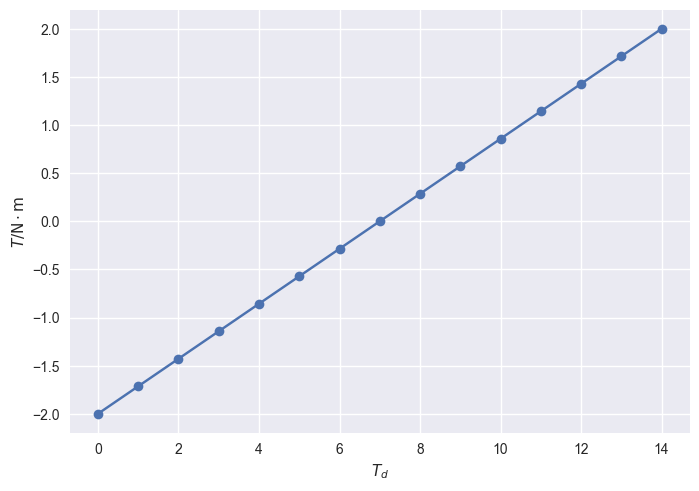

In [7]:
d_T = 15

cos_theta = np.linspace(-1, 1, 10000)
sin_theta = np.linspace(-1, 1, 10000)
omega = np.linspace(-8, 8, 10000)
T = np.arange(0, d_T, 1)

disc_states = np.array([discretize_state(np.array([c, s, o])) for c, s, o in zip(cos_theta, sin_theta, omega)])
cont_actions = [continualize_action(np.array(t)) for t in T]

plt.plot(cos_theta, disc_states[:, 0])
plt.xlabel(r"cos$(\theta)$, sin$(\theta)$")
plt.ylabel(r"cos${}_d$, sin${}_d$")
plt.grid('major')
plt.show()
plt.plot(omega, disc_states[:, 2])
plt.xlabel(r"$\omega / \frac{1}{\mathrm{s}}$")
plt.ylabel(r"$\omega_d$")
plt.grid('major')
plt.show()
plt.plot(T, cont_actions, 'o-')
plt.xlabel(r"$T_d$")
plt.ylabel(r"$T / \mathrm{N} \cdot \mathrm{m}$")
plt.grid('major')
plt.show()

## 1) n-Step Sarsa

Write an on-policy n-step Sarsa control algorithm for the inverted pendulum. 

Use the following parameters: $\alpha=0.1, \gamma=0.9, \varepsilon=0.1, n=10$ with 500 time steps in 2000 episodes.

![](nStepSARSA_Algo.png)

## Solution 1)

Execution might take long due to the "render" command, but this allows to observe the learning. Comment out to execute faster.

In [8]:
def policy(pi, state, deterministic, epsilon):
    """Decide on an action given the current state.

    Args:
        pi: The policy
        state: The current state of the environment
        epsilon: Probability for random action in eps-greedy

    Returns:
        action: The chosen action
    """
    ### BEGIN SOLUTION

    if not deterministic and (np.random.uniform(0, 1) < epsilon):
        action = np.random.choice(d_T) 
    else:
        action = pi[state]

    ### END SOLUTION
    return action
    

def interact(pi, action, done, states, rewards, actions, k, k_T, epsilon):
    """Interact with the environment to get to the next state. Note that
    the interaction is a different here, as this is a SARSA based algorithm.
    The action has already been decided on in the last step.

    Args:
        pi: The current policy
        action: The chosen action
        done: Whether the current episode is truncated/terminated
        states: A list of the states visited in the current episode
        rewards: A list of rewards gathered in the current episode
        actions: A list of actions applied in the current episode
        k: The current time index of the episode
        k_T: The termination time (initialized at +inf and set later to be able to deal with
            cases with variable episode lengths, e.g. the race track from previous exercises)
        epsilon: Probability for random action in eps-greedy

    Returns:
        next_state: The state after the interaction
        next_action: The action for the next timestep
        done: Whether the current episode is truncated/terminated in the next state
        states: A list of the states visited in the current episode including the new state
        rewards: A list of rewards gathered in the current episode including the new reward
        actions: A list of actions applied in the current episode including the new action
        k_T: The termination time, possibly updated
    """
    ### BEGIN SOLUTION
    
    cont_action = continualize_action(action)
    # env.render() # comment out for faster execution
    next_state, reward, terminated, truncated, _ = env.step(cont_action)
    done = terminated or truncated

    next_state = tuple(discretize_state(next_state))
   
    states.append(next_state)
    rewards.append(reward)

    # check if x_{k+1} is terminal
    if done:
        k_T = k+1
        next_action = None
    else:
        next_action = policy(pi, next_state, False, epsilon)
        actions.append(tuple([next_action]))

    ### END SOLUTION
    return next_state, next_action, done, states, rewards, actions, k_T
    

def learn(action_values, pi, states, actions, rewards, done, k, n, tau, discount_array, gamma, alpha, k_T):
    """Learn from your gathered data using n-step SARSA.

    Args:
        action_values: The action-values before the update
        pi: The policy before the update
        states: A list of the states visited in the current episode
        actions: A list of actions applied in the current episode
        rewards: A list of rewards gathered in the current episode
        done: Whether the current episode is truncated/terminated
        k: The current time index of the episode
        n: The number of learning steps
        tau: The time index for updating the estimate (lags behind the time index of the episode)
        discount_array: An array to weight the n learning steps with the discount factor
        gamma: The discount factor
        alpha: The step size / learning rate
        k_T: The termination time (initialized at +inf and set later to be able to deal with
            cases with variable episode lengths, e.g. the race track from previous exercises)

    Returns:
        action_values: The updated action values
        pi: The updated policy
    """
    ### BEGIN SOLUTION

    if done:
        # helps eliminate contemplation of rewards after termination
        rewards.append(0)

    last_rewards = rewards[-n:]
    g = (discount_array * last_rewards).sum()
    if tau + n < k_T:
        g += gamma ** n * action_values[states[k+1] + actions[k+1]]

    tau_state = states[tau]
    action_values[tau_state + actions[tau]] += alpha * (g - action_values[tau_state + actions[tau]])
    pi[tau_state] = np.argmax(action_values[tau_state])

    ### END SOLUTION
    return action_values, pi

In [9]:
env = gym.make('Pendulum-v1') # , render_mode="human"
env = env.unwrapped

nb_episodes = 2000  # number of episodes
nb_steps = 500  # length of episodes
env = TimeLimit(env, max_episode_steps=nb_steps)  # wrap the env for the new maximum step size

alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
epsilon = 0.1  # epsilon greedy parameter
n = 10  # prediction steps

action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
# int is necessary for indexing
pi = np.zeros([d_theta, d_theta, d_omega], dtype=int)

# we can use this to figure out how well the learning worked
cumulative_reward_history = []

for j in tqdm(range(nb_episodes), position=0, leave=True):

    states = []
    actions = []
    rewards = []

    # will be multiplied with the last rewards
    discount_array = gamma ** np.arange(n)

    cont_state, _ = env.reset()  # initialize x_0
    done = False

    state = tuple(discretize_state(cont_state))  # use tuple indexing
    action = pi[state]

    states.append(state)
    actions.append(tuple([action]))

    # terminal time
    k_T = np.inf
    k = 0

    while True:
        ### BEGIN SOLUTION

        # check x_k is not terminal (k < T)
        if k < k_T:
            state, action, done, states, rewards, actions, k_T = interact(
                pi, action, done, states, rewards, actions, k, k_T, epsilon
            )

        tau = k - n + 1
        if tau >= 0:  # test if agent waited long enough to learn
            action_values, pi = learn(
                action_values, pi, states, actions, rewards, done, k, n, tau, discount_array, gamma, alpha, k_T
            )

        if tau == k_T - 1:
            break

        k += 1
        ### END SOLUTION

    cumulative_reward_history.append(np.sum(rewards))

env.close()
pi_learned = np.copy(pi)  # save pi in cache under different name for later

  0%|          | 0/2000 [00:00<?, ?it/s]

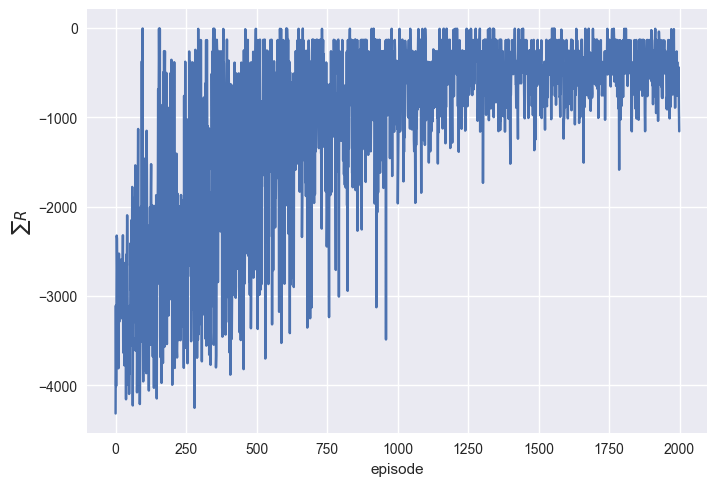

(2000,)


In [10]:
plt.plot(cumulative_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()

print(np.shape(cumulative_reward_history))

## Greedy Execution

Test the learned policy by pure greedy execution.

In [11]:
env = gym.make('Pendulum-v1', render_mode="human")
env = env.unwrapped

nb_steps = 200
env = TimeLimit(env, max_episode_steps=nb_steps)


state, _ = env.reset() # initialize x_0
disc_state = tuple(discretize_state(state)) # use tuple indexing
disc_action = pi_learned[disc_state]

while True:
        
    cont_action = continualize_action(disc_action)
    env.render() # comment out for faster execution
    state, reward, terminated, truncated, _ = env.step(cont_action)
    done = terminated or truncated

    disc_state = tuple(discretize_state(state))
        
    if done:
        break

    disc_action = pi_learned[disc_state] # exploitative action
    
env.close()

## 2) Recursive updates

Both, $n$-step and $\lambda$-return updates, are based on a forward view. That means we have to wait for future states and rewards before an update can be performed.
We therefore introduced the concept of eligibility traces, which follows the general idea that previous actions have significantly led to the current situation. Contrary to n-step learning, however, intuition tells us that more recent decisions had a more severe impact on the present situation than decisions that were made a long time ago. Thus, it may be helpful to integrate a forgetting factor $\lambda$ which decreases the assumed influence of actions over time.

Solution 2 is now to be changed by using eligibility traces $z_k(x_k)$ within the action-value update, resulting in SARSA($\lambda$). Note that the code is overall a lot less complex than the code from task 2 and much closer to the "normal" TD(0)-SARSA.

Test it for different values of $\lambda$. How sensitive is the process to the choice of $\lambda$?

In [12]:
def interact(pi, action, deterministic, epsilon):
    """Interact with the environment to get to the next state. Note that
    the interaction is a different here, as this is a SARSA based algorithm.
    The action has already been decided on in the last step.

    Args:
        pi: The current policy
        action: The chosen action

    Returns:
        next_state: The state after the interaction
        reward: The reward for the current interaction
        next_action: The action for the next timestep
        done: Whether the current episode is truncated/terminated in the next state
    """
    ### BEGIN SOLUTION
    
    cont_action = continualize_action(action)
    # env.render() # comment out for faster execution
    next_state, reward, terminated, truncated, _ = env.step(cont_action)
    done = terminated or truncated

    next_state = tuple(discretize_state(next_state))
    next_action = policy(pi, next_state, deterministic, epsilon)

    ### END SOLUTION
    return next_state, reward, next_action, done


def learn(action_values, pi, state, next_state, reward, action, next_action, eligibility, lambd, gamma, alpha):
    """Learn from your gathered data using SARSA(lambda). Note that the structures to deal with 
    the terminal state from the last task are not needed in this algorithm. The information from
    the past is saved in the eligibility trace.

    Args:
        action_values: The action-values before the update
        pi: The policy before the update
        state: State before the last interaction
        next_state: State after the last interaction
        reward: Reward for the interaction
        action: Action in the last interaction
        next_action: Action for the coming interaction
        eligibility: The eligibility trace
        lambd: Decay factor
        gamma: Discount factor
        alpha: Step size / learning rate

    Returns:
        action_values: The updated action values
        pi: The updated policy
    """
    ### BEGIN SOLUTION

    state_action = state + (action,)
    next_state_action = next_state + (next_action,)

    delta = reward + gamma * action_values[next_state_action] - action_values[state_action]

    action_values += alpha * delta * eligibility

    pi[state] = np.argmax(action_values[state])
    ### END SOLUTION
    return action_values, pi

In [13]:
env = gym.make('Pendulum-v1') # , render_mode="human"
env = env.unwrapped

nb_episodes = 2000  # number of episodes
nb_steps = 500  # length of episodes
env = TimeLimit(env, max_episode_steps=nb_steps)

alpha = 0.1  # learning rate
gamma = 0.9  # discount factor
epsilon = 0.1  # epsilon greedy parameter
lambd = 0.8  # forgetting factor

action_values = np.zeros([d_theta, d_theta, d_omega, d_T])
# int is necessary for indexing
pi = np.zeros([d_theta, d_theta, d_omega], dtype=int)

# we can use this to figure out how well the learning worked
cumulative_reward_history = []

for j in tqdm(range(nb_episodes), position=0, leave=True):

    # init eligibility trace, acts as the memory of this algorithm
    eligibility = np.zeros([d_theta, d_theta, d_omega, d_T])

    cont_state, _ = env.reset()  # initialize x_0
    done = False

    state = tuple(discretize_state(cont_state))  # use tuple indexing
    action = pi[state]

    # update eligibilities
    eligibility *= lambd * gamma
    eligibility[state, (action,)] += 1.0

    # terminal time
    k_T = None
    k = 0

    rewards = 0

    while True:
        ### BEGIN SOLUTION

        next_state, reward, next_action, done = interact(pi, action, False, epsilon)

        # update eligibilities
        eligibility *= lambd * gamma
        eligibility[state + (action,)] += 1.0
        
        action_values, pi = learn(
            action_values, pi, state, next_state, reward, action, next_action, eligibility, lambd, gamma, alpha
        )

        state = next_state
        action = next_action

        ### END SOLUTION

        rewards += reward
        if done:
            break

    cumulative_reward_history.append(np.sum(rewards))

env.close()

### END SOLUTION

  0%|          | 0/2000 [00:00<?, ?it/s]

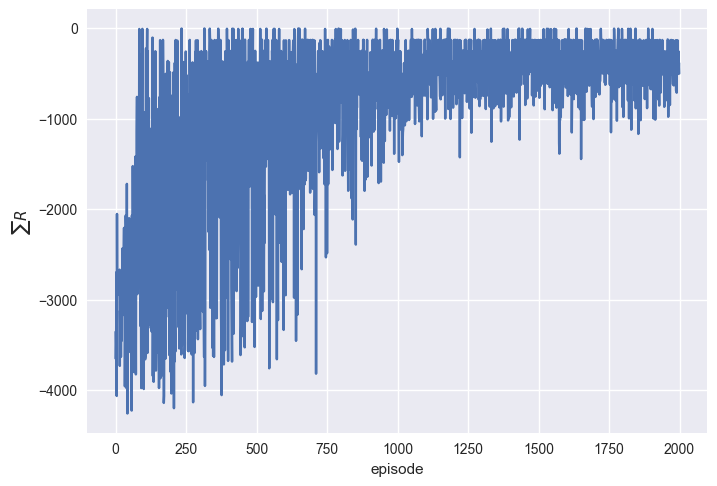

(2000,)


In [14]:
plt.plot(cumulative_reward_history)
plt.xlabel("episode")
plt.ylabel(r"$\sum R$")
plt.show()

print(np.shape(cumulative_reward_history))

## Greedy Execution

Test the learned policy by pure greedy execution.

In [15]:
env = gym.make('Pendulum-v1', render_mode="human")
env = env.unwrapped

nb_steps = 200

state, _ = env.reset() # initialize x_0
disc_state = tuple(discretize_state(state)) # use tuple indexing
disc_action = pi[disc_state]

for k in range(nb_steps):
        
    next_state, reward, next_action, done = interact(pi, action, True, epsilon)

    state = next_state
    action = next_action
    if done:
        break
    
env.close()